In [26]:
import numpy as np
import re, json, csv
from matplotlib import pyplot as plt
from pymongo import MongoClient
from tqdm.notebook import tqdm
from pprint import PrettyPrinter
from typing import Union, Iterable
from bson.objectid import ObjectId

pprint = PrettyPrinter().pprint

In [2]:
db = MongoClient("mongodb://localhost:27017")["cuda_snippets"]
train_db = db["train"]
validation_db = db["validation"]
repo_metadata_db = db["repo_metadata"]
file_metadata_db = db["file_metadata"]

In [17]:
repo_metadata_db.create_index("full_name")

file_metadata_db.create_index("repo_name")

'repo_name_1'

In [3]:
def sum_dicts(*ds) -> dict:
    result = {}
    for d in ds:        
        for k, v in d.items():
            if k not in result:
                result[k] = 0
            result[k] += v
    
    return result

sort_dict_by_val_desc = lambda d: sorted(d.items(), key=lambda x : x[1], reverse=True)

In [4]:
with open("../utils/repo_metadata.json", "r") as fd:
    repo_archive_metadata_content = json.load(fd)
    
repo_metadata_dict = {}
already_present = 0
for full_name, metadata in repo_archive_metadata_content.items():
    if metadata.get("files") is None:
        continue

    if full_name in repo_metadata_dict:
        already_present += 1
    else:
        repo_metadata_dict[metadata.get("files")[0][:-1]] = full_name

print(f"Total repos: {len(repo_archive_metadata_content)}")
print(f"Mapped: {len(repo_metadata_dict)}")
print(f"Duplicated names: {already_present}")

Total repos: 25130
Mapped: 13865
Duplicated names: 0


### Map repository info to kernels in DB

In [10]:

mapped = 0
not_mapped = []

# Iterate over train collection
for kernel in tqdm(train_db.find({})):
    repo_kernel_name = kernel.get("repo_name")
    if repo_kernel_name in repo_metadata_dict:
        mapped += 1
        if kernel.get("repo_metadata_id") is not None:
            continue
        repo_metadata = repo_metadata_db.find_one({"full_name" : repo_metadata_dict[repo_kernel_name]})
        train_db.find_one_and_update({"_id" : kernel.get("_id")}, {"$set" : {"repo_metadata_id" : str(repo_metadata.get("_id")) if repo_metadata else None}})
    else:
        not_mapped.append(kernel.get("repo_name"))

# Iterate over validation collection
for kernel in tqdm(validation_db.find({})):
    repo_kernel_name = kernel.get("repo_name")
    if repo_kernel_name in repo_metadata_dict:
        mapped += 1
        if kernel.get("repo_metadata_id") is not None:
            continue
        repo_metadata = repo_metadata_db.find_one({"full_name" : repo_metadata_dict[repo_kernel_name]})
        validation_db.find_one_and_update({"_id" : kernel.get("_id")}, {"$set" : {"repo_metadata_id" : str(repo_metadata.get("_id")) if repo_metadata else None}})
    else:
        not_mapped.append(kernel.get("repo_name"))

# Update file metadata
for archive_name, full_name in tqdm(repo_metadata_dict.items()):
    repo_metadata = repo_metadata_db.find_one({"full_name" : full_name})
    file_metadata_db.update_many({"repo_name" : archive_name}, {"$set" : { "repo_metadata_id" : str(repo_metadata.get("_id")) if repo_metadata else None}})


print(f"Found: {mapped}")
print(f"Not found : {len(not_mapped)}")
print(f"Ratio: {mapped/(mapped+len(not_mapped)):.2%}")

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/13865 [00:00<?, ?it/s]

Found: 480778
Not found : 5622
Ratio: 98.84%


In [14]:
not_mapped_repos_set = set(not_mapped)
print(f"not mapped repositories: {len(not_mapped_repos_set)}")
print(not_mapped_repos_set)

repo_metadata_ids_of_not_mapped_kernels = set(train_db.distinct("repo_metadata_id", {"repo_name" : {"$in" : list(not_mapped_repos_set)}}) + \
    validation_db.distinct("repo_metadata_id", {"repo_name" : {"$in" : list(not_mapped_repos_set)}}))
    
print(f"Got {len(repo_metadata_ids_of_not_mapped_kernels)} values")
print(repo_metadata_ids_of_not_mapped_kernels)

not mapped repositories: 7
{'alien-develop', 'cudf-branch-23.04', 'cupy-master', 'cutlass-master', 'thrust-main', 'tsne-cuda-main', 'cuml-branch-23.04'}
Got 7 values
{'6436e4ebdba5500b741dcf56', '6436e4e8dba5500b741dcf4a', '6436e4e9dba5500b741dcf4e', '641ac12cab0c677c51ed2dc4', '6436e4eadba5500b741dcf50', '6436e4e9dba5500b741dcf4d', '6436e4e9dba5500b741dcf4f'}


In [7]:
not_mapped_repos_grouped = sum_dicts(
    {repo.get("_id") : repo.get("count") for repo in train_db.aggregate([
        {"$match" : {"$or" : [
            {"repo_metadata_id" : {"$exists" : False}},
            {"repo_metadata_id" : None}
            ]}
        },
        {"$group" : {"_id" : "$repo_name", "count" : {"$sum" : 1}}}
    ])},
    {repo.get("_id") : repo.get("count") for repo in validation_db.aggregate([
        {"$match" : {"$or" : [
            {"repo_metadata_id" : {"$exists" : False}},
            {"repo_metadata_id" : None}
            ]}
        },
        {"$group" : {"_id" : "$repo_name", "count" : {"$sum" : 1}}}
    ])},
)

print(f"Not mapped kernels: {sum(not_mapped_repos_grouped.values())}")
print(f"Not mapped repositories: {len(not_mapped_repos_grouped.keys())}")
not_mapped_in_db = repo_metadata_db.count_documents({"full_name" : {"$in" : [repo_metadata_dict.get(repo_name) for repo_name in not_mapped_repos_grouped.keys()]}})
print(f"Not mapped in DB: {not_mapped_in_db}")


Not mapped kernels: 0
Not mapped repositories: 0
Not mapped in DB: 0


In [7]:
def update_repo_dependencies(repo_name : str, repo_full_name):
    repo_metadata = repo_metadata_db.find_one({"full_name" : repo_full_name})
    
    file_metadata_db.update_many({"repo_name" : repo_name}, {"$set" : { "repo_metadata_id" : str(repo_metadata.get("_id"))}})
    train_db.update_many({"repo_name" : repo_name}, {"$set" : { "repo_metadata_id" : str(repo_metadata.get("_id"))}})
    validation_db.update_many({"repo_name" : repo_name}, {"$set" : { "repo_metadata_id" : str(repo_metadata.get("_id"))}})

manual_addon = {
    "cuml-branch-23.04" : "rapidsai/cuml",
    "cupy-master" : "cupy/cupy",
    "cudf-branch-23.04" : "rapidsai/cudf",
    "thrust-main" : "NVIDIA/thrust",
    "cutlass-master" : "NVIDIA/cutlass",
    "alien-develop" : "chrxh/alien",
    "tsne-cuda-main" : "CannyLab/tsne-cuda"
}

for repo_name, repo_full_name in manual_addon.items():
    update_repo_dependencies(repo_name, repo_full_name)

Not mapped kernels: 40678
Not mapped repositories: 787
Not mapped in DB: 0


In [13]:
not_mapped_repos_sorted = sort_dict_by_val_desc(not_mapped_repos_grouped)
print("First 10 most missed repos:")
for i, repo in enumerate(not_mapped_repos_sorted[:10], 1):
    print(f"{i}.\t{repo}")



First 10 most missed repos:
1.	('cuda-half2-master', 2132)
2.	('pytorch-master', 1979)
3.	('EnsembleClusteringParallelCUDA-master', 1240)
4.	('CUDA_exercises-master', 1239)
5.	('cuda_examples-master', 1129)
6.	('NVIDIA_Cuda-Samples-master', 1102)
7.	('Nvidia-CUDA-Samples-master', 1102)
8.	('nvidia-master', 1072)
9.	('v11.1-main', 1042)
10.	('Particles-master', 1032)


In [8]:
def split_to_key_and_val(line : str) -> dict:
    key, val = line.split(",")
    return {key.strip() : val.strip()} 

with open("../utils/bq-results-joint.csv", "r") as fd:
    bq_full_name_url_dict = { key : val for line in fd.readlines()[1:] for key, val in split_to_key_and_val(line).items()}

addon = []
for repo_name in tqdm(not_mapped_repos_grouped.keys()):
    full_name = repo_metadata_dict.get(repo_name)
    if full_name is None:
        tqdm.write(f"Skipping: '{repo_name}'. Not found in repo_metadata_dict")
        continue
    
    url = bq_full_name_url_dict.get(full_name)
    if url is None:
        tqdm.write(f"Skipping: '{repo_name}'. Not found in bq_full_name_url_dict")
        continue
    
    addon.append(f"{full_name},{url}\n")

print(f"Got total number of non-mapped repos: {len(addon)}")
with open("../utils/addon.csv", "w") as fd:
    fd.writelines(addon)

0it [00:00, ?it/s]

Got total number of non-mapped repos: 0


### Check not ready repos

In [20]:
not_finished_repos_count = repo_metadata_db.count_documents({"status" : "PENDING"})
print(f"Got {not_finished_repos_count} not finished repos")

not_finished_repos = repo_metadata_db.find({"status" : "PENDING"})
download_again_repos_ids = []
for not_finished_repo in not_finished_repos:
    full_name = not_finished_repo.get("full_name")
    if full_name is None:
        raise Exception("full_name is None")
    
    finished_repos = repo_metadata_db.count_documents({"full_name" : full_name, "status" : "READY"})
    if finished_repos == 0:
        download_again_repos_ids.append(str(not_finished_repo.get("_id")))

print(f"Not finished repository metadata in DB {len(download_again_repos_ids)}")

invalid_repo_id_kernels_count = train_db.count_documents({"repo_metadata_id" : {"$in" : download_again_repos_ids}}) + \
    validation_db.count_documents({"repo_metadata_id" : {"$in" : download_again_repos_ids}})

print(f"Number of kernels mapped to invalid repo_metadata: {invalid_repo_id_kernels_count}") 


Got 2344 not finished repos
Not finished repository metadata in DB 2344
Number of kernels mapped to invalid repo_metadata: 32889


### Sort repositories by metric counts

In [50]:
metrics = ["watchers_count", "subscribers_count", "stargazers_count"]
weights = [0.8, 1, 1]

used_repos_ids = set(train_db.distinct("repo_metadata_id") + validation_db.distinct("repo_metadata_id"))


matcher = {"$match" : {**{name : {"$exists" : True} for name in metrics}, "_id" : {"$in" : [ObjectId(idx) for idx in used_repos_ids]}}}
projection = {"$project" : {**{name : f"${name}" for name in metrics}, "full_name" : "$full_name"}}

repos = list(repo_metadata_db.aggregate([
    matcher,
    projection
]))

print(f"Got {len(repos)} valid repos")

for i, repo in enumerate(repos):
    score = sum(repo.get(metric) * weight for metric, weight in zip(metrics, weights))
    repos[i]["total_score"] = score
    repo_metadata_db.update_one({"_id" : repo.get("_id")}, {"$set" : {"total_score" : score}})
    
repo_score_sorted = sorted(repos, key=lambda repo: repo.get("total_score"), reverse=True)  

Got 6426 valid repos


i.	full name	 watchers_count	subscribers_count	stargazers_count	total score
1.	kaldi-asr/kaldi		 12604, 702, 12604 -> 23389.20
2.	NVlabs/instant-ngp		 11971, 181, 11971 -> 21728.80
3.	isl-org/Open3D		 8440, 172, 8440 -> 15364.00
4.	catboost/catboost		 7068, 193, 7068 -> 12915.40
5.	cupy/cupy		 6820, 129, 6820 -> 12405.00
6.	rapidsai/cudf		 5445, 137, 5445 -> 9938.00
7.	Oneflow-Inc/oneflow		 4882, 128, 4882 -> 8915.60
8.	NVIDIA/thrust		 4467, 205, 4467 -> 8245.60
9.	arrayfire/arrayfire		 4103, 151, 4103 -> 7536.40
10.	rapidsai/cuml		 3254, 70, 3254 -> 5927.20
Total kernels: 486400
First 10 repos kernels: 9715
Ratio: 2.00%


  0%|          | 0/6426 [00:00<?, ?it/s]

Pearson correlation score: 0.08


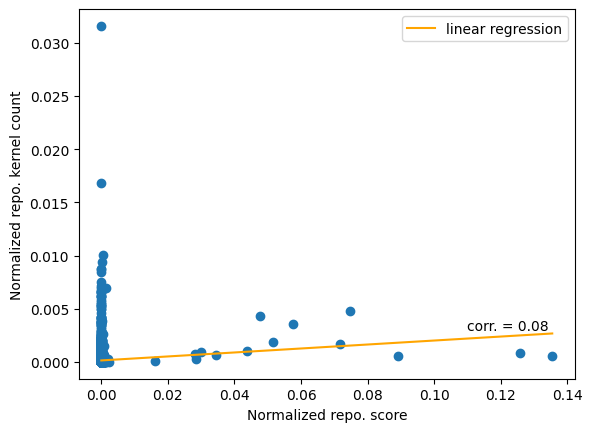

Highest kernel count repository is 6413. in total score out of total 6426 repos.


In [61]:
train_db.create_index("repo_metadata_id")
validation_db.create_index("repo_metadata_id")
from sklearn.linear_model import LinearRegression 

def count_kernels_for_repo_id(repo_id : Union[str, list]) -> int:
    if type(repo_id) is str:
        repo_id = [repo_id] 

    return train_db.count_documents({"repo_metadata_id" : {"$in" : repo_id}}) + \
        validation_db.count_documents({"repo_metadata_id" : {"$in" : repo_id}})
        
show_first_n = 10
print("i.\tfull name\t {}\ttotal score".format("\t".join(metrics)))
for i, repo in enumerate(repo_score_sorted[:show_first_n], 1):
    print("{}.\t{}\t\t {}, {}, {} -> {:.2f}".format(i, repo.get("full_name"), *[repo.get(metric) for metric in metrics], repo.get("total_score")))

firt_n_repos = repo_score_sorted[:show_first_n]
first_n_repos_ids = [str(repo.get("_id")) for repo in firt_n_repos]

first_repos_kernel_count = count_kernels_for_repo_id(first_n_repos_ids)

# Normalizing consts
total_kernel_count = train_db.count_documents({}) + validation_db.count_documents({})
total_repository_score = sum([repo.get("total_score") for repo in repo_score_sorted])

print(f"Total kernels: {total_kernel_count}")
print(f"First {show_first_n} repos kernels: {first_repos_kernel_count}")
print(f"Ratio: {first_repos_kernel_count/total_kernel_count:.2%}")

normalized_scores = []
normalized_kernel_count = []
for repo in tqdm(repo_score_sorted):
    normalized_scores.append(repo.get("total_score") / total_repository_score)
    normalized_kernel_count.append(count_kernels_for_repo_id(str(repo.get("_id"))) / total_kernel_count)

regressor = LinearRegression() 
regressor.fit(np.array(normalized_scores).reshape(-1, 1), normalized_kernel_count) 
linear_regression = regressor.predict(np.array(normalized_scores).reshape(-1, 1))

from scipy.stats import pearsonr

corr = pearsonr(normalized_scores, normalized_kernel_count)[0]
print("Pearson correlation score: {:.2f}".format(corr))


plt.xlabel("Normalized repo. score")
plt.ylabel("Normalized repo. kernel count")
plt.scatter(normalized_scores, normalized_kernel_count)
plt.plot(normalized_scores, linear_regression, label="linear regression", color="orange")
plt.text(0.11, 0.003, f"corr. = {corr:.2f}")
plt.legend()
plt.show()


highest_kernel_count_repo_idx = np.argmax(normalized_kernel_count)
print(f"Highest kernel count repository is {highest_kernel_count_repo_idx}. in total score out of total {len(repos)} repos.")

